# Time Leading, Traing Ties v2.0
- Started 11-11-24

In [364]:
### Path to Target Database file
import os
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.legend_handler import HandlerTuple
from matplotlib.legend_handler import HandlerBase
from PIL import Image

# path to database file using os module
# data\db\2024_Nov_7_SEMI_CLEAN.db
db_path = os.path.join('..', 'data', 'db', '2024_Nov_11_SEMI_CLEAN.db') # Path to most recent cleaned DB File
conn = sqlite3.connect(db_path)

# output_file_path = '../TEMP/lead_Trail_season_aggregate_states.csv' # Original Path - power BI report is tied to tis file location
output_file_path = '../TEMP/Lead_Trail_v2_TEST.csv'

# verify the connection
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# extract scoring table from database
scoring_query = "SELECT * FROM scoring_summary"
scoring_df = pd.read_sql_query(scoring_query, conn)

### Dictionaries and Constants

In [365]:
# path to TEMP folder
temp_folder = os.path.join(os.getcwd(), '..', 'TEMP')
# Data folder
data_folder = os.path.join(os.getcwd(), '..', 'data')
# Image folder
img_folder = os.path.join(os.getcwd(), '..', 'images')
# Logo folder
logo_folder = os.path.join(os.getcwd(), '..', 'images', 'logos')

# Path to school info table (csv)
school_info_file = os.path.join(data_folder, 'arena_school_info.csv')
school_info_df = pd.read_csv(school_info_file)

## Conference Membership

atlantic = ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
            'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart', 'St Lawrence']

big_ten = ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin']

ccha = ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
        'Minnesota State', 'Northern Michigan', 'St Thomas']

ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']

hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']

nchc = ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 'St Cloud State',
        'Western Michigan']

independents = ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill']

# Create a dictionary of {Team: logo_abv} for each team with .png added to the end
logo_mapping = {}

for index, row in school_info_df.iterrows():
    logo_mapping[row['Team']] = row['logo_abv'] + '.png'

# print(logo_mapping)

In [366]:
title_font_size = 28

legend_font_size = 16
set_x_label_font_size = 16

### Select scoring summary table 

In [367]:
# Step 1: Preprocess the data to convert 'Time' and 'Period' into cumulative seconds
def convert_time_to_seconds(time_str):
    """Convert 'MM:SS' format to total seconds."""
    minutes, seconds = map(int, time_str.split(':'))
    return minutes * 60 + seconds

def convert_period_to_seconds(period, time_in_period):
    """Convert period and time in period to cumulative game seconds."""
    base_time = 0
    if period == '1st Period':
        base_time = 0
    elif period == '2nd Period':
        base_time = 1200  # 20 minutes
    elif period == '3rd Period':
        base_time = 2400  # 40 minutes
    elif period == 'Overtime':
        base_time = 3600  # 60 minutes (end of regulation)
    return base_time + time_in_period

# Apply the conversions to the dataframe
scoring_df['Time_Seconds'] = scoring_df['Time'].apply(convert_time_to_seconds)
scoring_df['Cumulative_Seconds'] = scoring_df.apply(
    lambda row: convert_period_to_seconds(row['Period'], row['Time_Seconds']), axis=1
)

# Sort the dataframe by Game_ID and Cumulative_Seconds to process goals in order
scoring_df.sort_values(by=['Game_ID', 'Cumulative_Seconds'], inplace=True)

# Display the processed dataframe to check the conversion results
# import ace_tools as tools; tools.display_dataframe_to_user(name="Processed Scoring Data", dataframe=scoring_df)


In [368]:
from collections import defaultdict

def calculate_game_states(scoring_df):
    """
    Calculate time spent in different game states (tied, leading by 1, leading by 2+, trailing by 1, etc.)
    for each team in each game.
    """
    # Initialize a dictionary to store results
    results = defaultdict(lambda: defaultdict(int))
    
    # Group by each game and sort by cumulative seconds
    games = scoring_df.groupby('Game_ID')
    
    for game_id, game_data in games:
        game_data = game_data.sort_values('Cumulative_Seconds')
        
        # Extract home and away teams
        home_team = game_data['Home_Team'].iloc[0]
        away_team = game_data['Away_Team'].iloc[0]
        
        # Initialize scores and time tracking
        scores = {home_team: 0, away_team: 0}
        previous_time = 0
        
        # Function to determine game state
        def get_game_state(team, scores):
            opponent = home_team if team == away_team else away_team
            goal_diff = scores[team] - scores[opponent]
            
            if goal_diff == 0:
                return 'Tied'
            elif goal_diff == 1:
                return 'Leading by 1'
            elif goal_diff == 2:
                return 'Leading by 2'
            elif goal_diff >= 3:
                return 'Leading by 3+'
            elif goal_diff == -1:
                return 'Trailing by 1'
            elif goal_diff == -2:
                return 'Trailing by 2'
            else:
                return 'Trailing by 3+'

        # Track the game states as goals are scored
        for _, row in game_data.iterrows():
            current_time = row['Cumulative_Seconds']
            elapsed_time = current_time - previous_time
            
            # Calculate the current state for both teams before the goal
            for team in [home_team, away_team]:
                state = get_game_state(team, scores)
                results[team][state] += elapsed_time
            
            # Update the score for the team that scored
            scores[row['Team']] += 1
            
            # Update the previous time to the current goal time
            previous_time = current_time
        
        # Handle the final game state after the last goal to the end of the game (60 or 65 minutes)
        game_end_time = 3900 if 'Overtime' in game_data['Period'].values else 3600
        remaining_time = game_end_time - previous_time
        
        for team in [home_team, away_team]:
            state = get_game_state(team, scores)
            results[team][state] += remaining_time

    # Convert results to a DataFrame for easy analysis
    result_df = pd.DataFrame(results).fillna(0).transpose()
    result_df.reset_index(inplace=True)
    result_df.rename(columns={'index': 'Team'}, inplace=True)
    
    return result_df

# Calculate the game states using the function
game_states_df = calculate_game_states(scoring_df)

# Display the result
# tools.display_dataframe_to_user(name="Team Game State Analysis", dataframe=game_states_df)


In [369]:
# game_states_df

In [370]:
# ## As a QCheck get a total time and divide by 60 to get minutes
# # Set the index to the team name
# game_states_df.set_index('Team', inplace=True)
# game_states_df['Total_Time'] = game_states_df.sum(axis=1)
# game_states_df['Total_Time_Minutes'] = game_states_df['Total_Time'] / 60


# game_states_df.head(10)

### Calculate percentages for each game state

In [371]:
# Calculate the total time for each team and add the percentage columns
game_states_df['Total_Time'] = game_states_df[['Tied', 'Trailing by 1', 'Trailing by 2', 'Trailing by 3+',
                                               'Leading by 1', 'Leading by 2', 'Leading by 3+']].sum(axis=1)

# Calculate the percentage of time spent in each state
game_states_df['Tied_Percentage'] = game_states_df['Tied'] / game_states_df['Total_Time'] * 100
game_states_df['Leading_by_1_Percentage'] = game_states_df['Leading by 1'] / game_states_df['Total_Time'] * 100
game_states_df['Leading_by_2_Percentage'] = game_states_df['Leading by 2'] / game_states_df['Total_Time'] * 100
game_states_df['Leading_by_3+_Percentage'] = game_states_df['Leading by 3+'] / game_states_df['Total_Time'] * 100
game_states_df['Trailing_by_1_Percentage'] = game_states_df['Trailing by 1'] / game_states_df['Total_Time'] * 100
game_states_df['Trailing_by_2_Percentage'] = game_states_df['Trailing by 2'] / game_states_df['Total_Time'] * 100
game_states_df['Trailing_by_3+_Percentage'] = game_states_df['Trailing by 3+'] / game_states_df['Total_Time'] * 100

# Re-run the plotting function to visualize the top teams by leading percentage
# plot_top_teams_by_leading_percentage(game_states_df)




# Visualizations

### Options and Settings

In [372]:
## Set the figure size / ratio
set_fig_size = (9, 10)

## Color Scheme from the Original Tableau Viz
colors = [
    '#1A9850', '#65BD62', '#A6D86A',  # Leading: Dark Blue, Light Blue, Steel Blue
    '#FFFFBF',                        # Tied: Dark Gray
    '#FCAE62', '#F36D42', '#D73026'   # Trailing: Light Red, Orange Red, Dark Red
]

#### DEPREC - RECREATED IN ADJUST CODE BELOW

In [373]:
# import matplotlib.pyplot as plt
# from matplotlib.offsetbox import OffsetImage, AnnotationBbox
# import os

# def plot_top_teams_with_logos(game_states_df, logo_mapping, logo_folder, top_n=10):
#     """
#     Plot stacked bar charts of game state percentages for the top `top_n` teams,
#     with labels showing the percentage within each segment if space allows,
#     and team logos replacing the team names on the y-axis.
#     """
#     # Calculate the total leading percentage
#     game_states_df['Total_Leading_Percentage'] = (
#         game_states_df['Leading_by_1_Percentage'] +
#         game_states_df['Leading_by_2_Percentage'] +
#         game_states_df['Leading_by_3+_Percentage']
#     )
    
#     # Select the top teams by leading percentage
#     top_teams_df = game_states_df.nlargest(top_n, 'Total_Leading_Percentage')
    
#     # Prepare data for plotting
#     categories = [
#         'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
#         'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
#     ]
    
#     colors = [
#         '#1A9850', '#65BD62', '#A6D86A',  # Leading: Shades of Green
#         '#FFFFBF',                        # Tied: Yellow
#         '#FCAE62', '#F36D42', '#D73026'   # Trailing: Shades of Red
#     ]

#     custom_labels = [
#         'Lead 3+', 'Lead 2', 'Lead 1', 
#         'Tied', 'Down 1', 'Down 2', 'Down 3+'
#     ]
    
#     fig, ax = plt.subplots(figsize=set_fig_size)
    
#     bottom = None
#     for category, color in zip(categories, colors):
#         if bottom is None:
#             bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
#             bottom = top_teams_df[category]
#         else:
#             bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
#             bottom += top_teams_df[category]
        
#         # Add labels to the segments where there's enough space
#         for bar, value in zip(bars, top_teams_df[category]):
#             if value > 5:  # Only show labels if the segment is larger than 5%
#                 ax.text(
#                     bar.get_x() + bar.get_width() / 2,  # Center of the segment
#                     bar.get_y() + bar.get_height() / 2,  # Center of the bar
#                     f"{value:.1f}%",  # Label with one decimal place
#                     ha='center', va='center', fontsize=12, color='black'
#                 )

# ####### ADD TEAM LOGOS TO THE CHART #######
#     # Add team logos in place of the y-axis labels
#     for i, team in enumerate(top_teams_df['Team']):
#         logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
#         if logo_path and os.path.exists(logo_path):
#             try:
#                 logo_img = plt.imread(logo_path)
#                 imagebox = OffsetImage(logo_img, zoom=0.15)
#                 ab = AnnotationBbox(imagebox, (0, i), frameon=False, boxcoords="offset points", 
#                                     xybox=(-25, 0), pad=0, xycoords='data')
#                 ax.add_artist(ab)
#             except Exception as e:
#                 print(f"Error adding logo for {team}: {e}")
    
#     # Remove y-axis labels since we are using logos
#     ax.set_yticks([])
    
#     # Customize the chart
#     ax.set_xlabel('Percentage of Game Time')
#     ax.set_title(f'Top {top_n} Teams by Percentage of Time Leading', fontsize=title_font_size)
#     ax.set_xlim(0, 100)
#     ax.set_xticks([25, 50, 75])

#     # Create a custom legend layout
#     legend_layout = [
#         ("Lead 3+", colors[0]), ("Lead 2", colors[1]), ("Lead 1", colors[2]),
#         ("", ""), ("Tied", colors[3]), ("", ""),
#         ("Down 1", colors[-3]), ("Down 2", colors[-2]), ("Down 3+", colors[-1])
#     ]

#     # legend_layout = [
#     #     ("Lead 3+", colors[0]), ("", ""), ("Down 3+", colors[-1]),
#     #     ("Lead 2", colors[1]), ("Tied", colors[3]), ("Down 2", colors[-2]),
#     #     ("Lead 1", colors[2]), ("", ""), ("Down 1", colors[-3])
#     # ]
    
#     # Extract handles and labels from the legend layout
#     handles = []
#     labels = []
#     for label, color in legend_layout:
#         if label:  # Only create handles for non-empty cells
#             handles.append(plt.Rectangle((0, 0), 1, 1, color=color))
#             labels.append(label)
#         else:
#             handles.append(plt.Rectangle((0, 0), 0, 0, color='none'))  # Empty placeholder
#             labels.append("")  # Empty label for spacing
    
#     # Create the custom legend
#     ax.legend(
#         handles, labels, loc='upper center',
#         bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=False,
#         fontsize=legend_font_size, columnspacing=1.5, handletextpad=0.5, labelspacing=.750
#     )    
    
#     # # Customize the legend with 3 rows
#     # handles, _ = ax.get_legend_handles_labels()
#     # ax.legend(
#     #     handles, custom_labels, loc='upper center',
#     #     bbox_to_anchor=(0.5, -0.15), ncol=4,
#     #     frameon=False, fontsize=10,
#     #     columnspacing=1.0, handletextpad=0.5,
#     #     labelspacing=1.0
#     # )
    
#     plt.grid(axis='x', linestyle='--', alpha=0.6)
#     plt.tight_layout()
#     plt.gca().invert_yaxis()  # Ensure top team is at the top of the chart
#     plt.show()

# plot_top_teams_with_logos(game_states_df, logo_mapping, logo_folder, top_n=10)


#### Adjustable Plot Backend

In [374]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os

def plot_team_comparison(game_states_df, logo_mapping, logo_folder, plot_type, top_n=10):
    """
    Plot stacked bar charts of game state percentages for the top `top_n` teams,
    with labels showing the percentage within each segment if space allows,
    and team logos replacing the team names on the y-axis.
    
    Parameters:
    - game_states_df: DataFrame containing game state data.
    - logo_mapping: Dictionary mapping team names to logo file names.
    - logo_folder: Folder path where logos are stored.
    - plot_type: Type of plot ("leading", "trailing", "tied", "least_tied").
    - top_n: Number of top teams to display.
    """
    
    # Calculate the total percentages for leading, trailing, and tied states
    game_states_df['Total_Leading_Percentage'] = (
        game_states_df['Leading_by_1_Percentage'] +
        game_states_df['Leading_by_2_Percentage'] +
        game_states_df['Leading_by_3+_Percentage']
    )
    game_states_df['Total_Trailing_Percentage'] = (
        game_states_df['Trailing_by_1_Percentage'] +
        game_states_df['Trailing_by_2_Percentage'] +
        game_states_df['Trailing_by_3+_Percentage']
    )
    game_states_df['Total_Tied_Percentage'] = game_states_df['Tied_Percentage']

    # Select the top teams based on the chosen plot type
    if plot_type == "leading":
        top_teams_df = game_states_df.nlargest(top_n, 'Total_Leading_Percentage')
        title = f"Highest % of Game Time Leading"
    elif plot_type == "trailing":
        top_teams_df = game_states_df.nlargest(top_n, 'Total_Trailing_Percentage')
        title = f"Highest % of Game Time Trailing"
    elif plot_type == "tied":
        top_teams_df = game_states_df.nlargest(top_n, 'Total_Tied_Percentage')
        title = f"Highest % of Game Time Tied"
    elif plot_type == "least_tied":
        top_teams_df = game_states_df.nsmallest(top_n, 'Total_Tied_Percentage')
        title = f"Lowest % of Game Time Tied"
    else:
        raise ValueError("Invalid plot type. Choose from 'leading', 'trailing', 'tied', 'least_tied'.")

    # Prepare data for plotting
    categories = [
        'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
        'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
    ]
    
    colors = [
        '#1A9850', '#65BD62', '#A6D86A',  # Leading: Shades of Green
        '#FFFFBF',                        # Tied: Yellow
        '#FCAE62', '#F36D42', '#D73026'   # Trailing: Shades of Red
    ]

    custom_labels = [
        'Lead 3+', 'Lead 2', 'Lead 1', 
        'Tied', 'Down 1', 'Down 2', 'Down 3+'
    ]
    
    fig, ax = plt.subplots(figsize=set_fig_size)
    
    bottom = None
    for category, color in zip(categories, colors):
        if bottom is None:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
            bottom = top_teams_df[category]
        else:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
            bottom += top_teams_df[category]
        
        # Add labels to the segments where there's enough space
        for bar, value in zip(bars, top_teams_df[category]):
            if value > 5:  # Only show labels if the segment is larger than 5%
                ax.text(
                    bar.get_x() + bar.get_width() / 2, 
                    bar.get_y() + bar.get_height() / 2, 
                    f"{value:.1f}%", ha='center', va='center', fontsize=12, color='black'
                )

    # Add team logos in place of the y-axis labels
    for i, team in enumerate(top_teams_df['Team']):
        logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
        if logo_path and os.path.exists(logo_path):
            try:
                logo_img = plt.imread(logo_path)
                imagebox = OffsetImage(logo_img, zoom=0.15)
                ab = AnnotationBbox(imagebox, (0, i), frameon=False, boxcoords="offset points", 
                                    xybox=(-25, 0), pad=0, xycoords='data')
                ax.add_artist(ab)
            except Exception as e:
                print(f"Error adding logo for {team}: {e}")

    # Remove y-axis labels since we are using logos
    ax.set_yticks([])
    
    # Customize the chart
    ax.set_xlabel('Percentage of Game Time', fontsize=set_x_label_font_size)
    ax.set_title(title, fontsize=title_font_size)
    ax.set_xlim(0, 100)
    ax.set_xticks([25, 50, 75])

    # Create a custom legend layout
    legend_layout = [
        ("Lead 3+", colors[0]), ("Lead 2", colors[1]), ("Lead 1", colors[2]),
        ("", ""), ("Tied", colors[3]), ("", ""),
        ("Down 1", colors[-3]), ("Down 2", colors[-2]), ("Down 3+", colors[-1])
    ]
    
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) if label else plt.Rectangle((0, 0), 0, 0, color='none')
               for label, color in legend_layout]
    labels = [label if label else "" for label, color in legend_layout]

    ax.legend(
        handles, labels, loc='upper center',
        bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=False,
        fontsize=legend_font_size, columnspacing=2.5, handletextpad=0.25, labelspacing=0.5
    )

    # Get todays date as a string for the footer
    from datetime import date
    today = date.today()
    todays_date = today.strftime("%m/%d/%Y")

    # add a note with the date the data was pulled and plotted
    ax.text(0.5, -0.20, f'Data Source: College Hockey News\nIncludes all games through {todays_date}', ha='center', va='bottom',
     fontsize=10, 
    transform=ax.transAxes
    )
    
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()


### Call The Plots

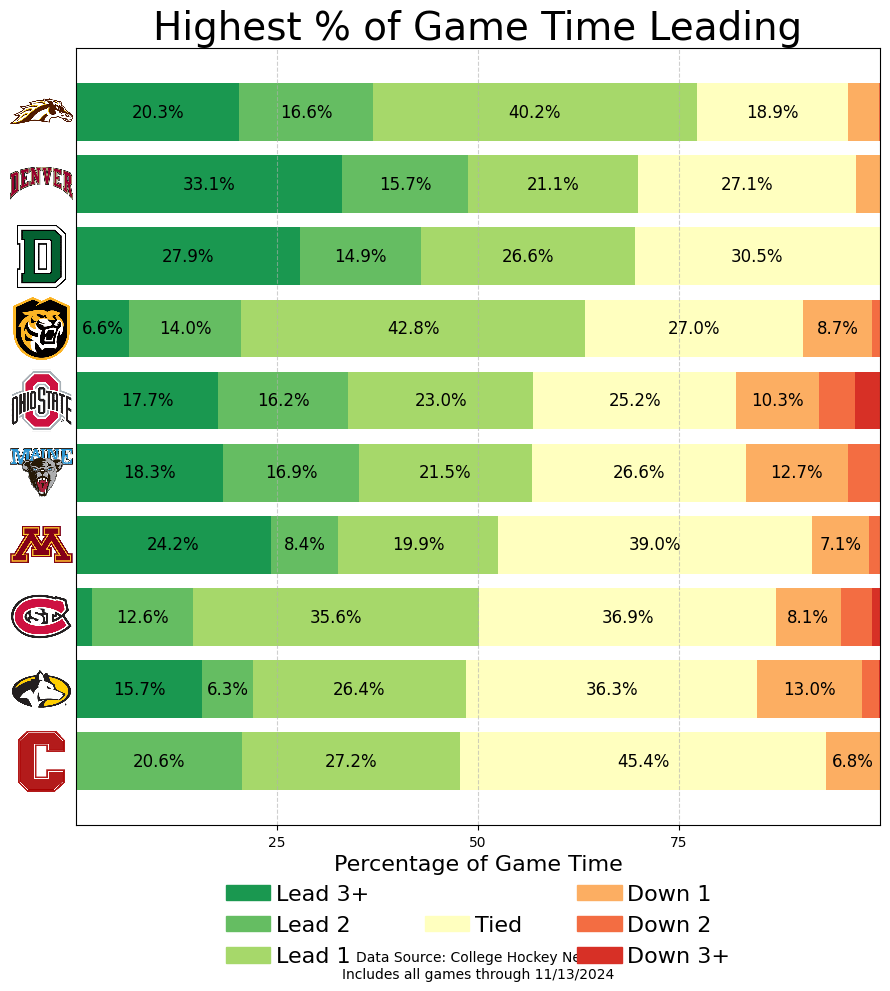

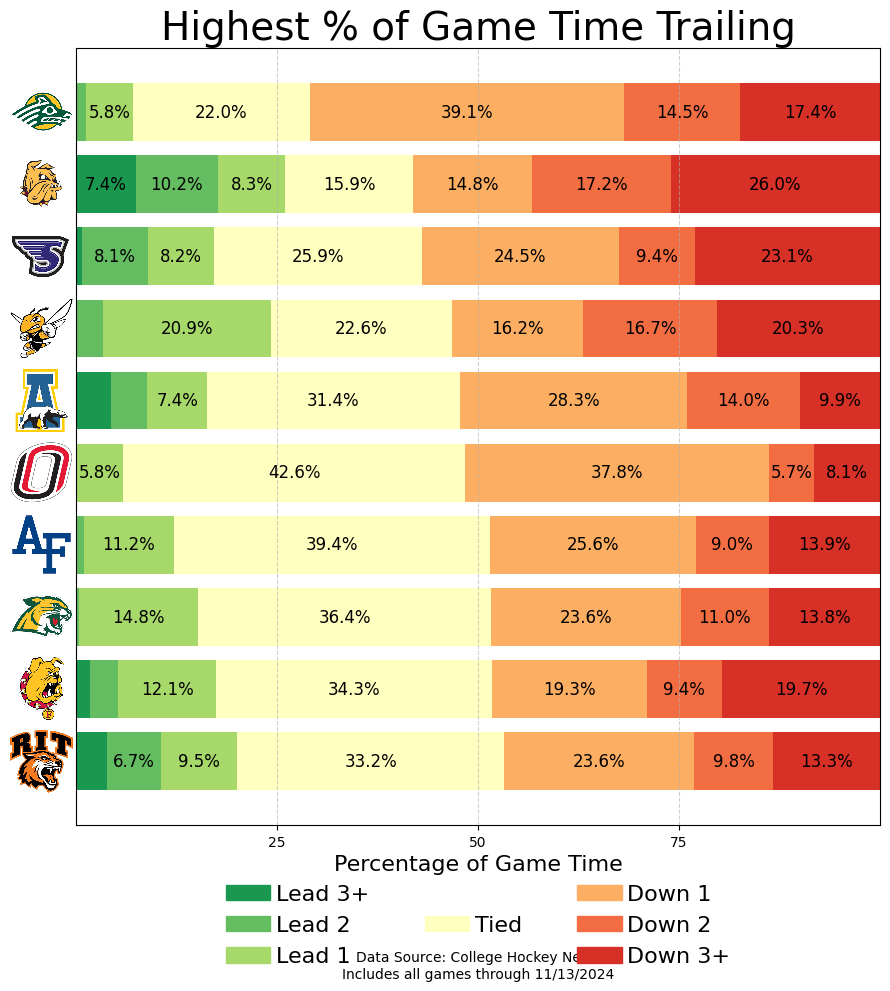

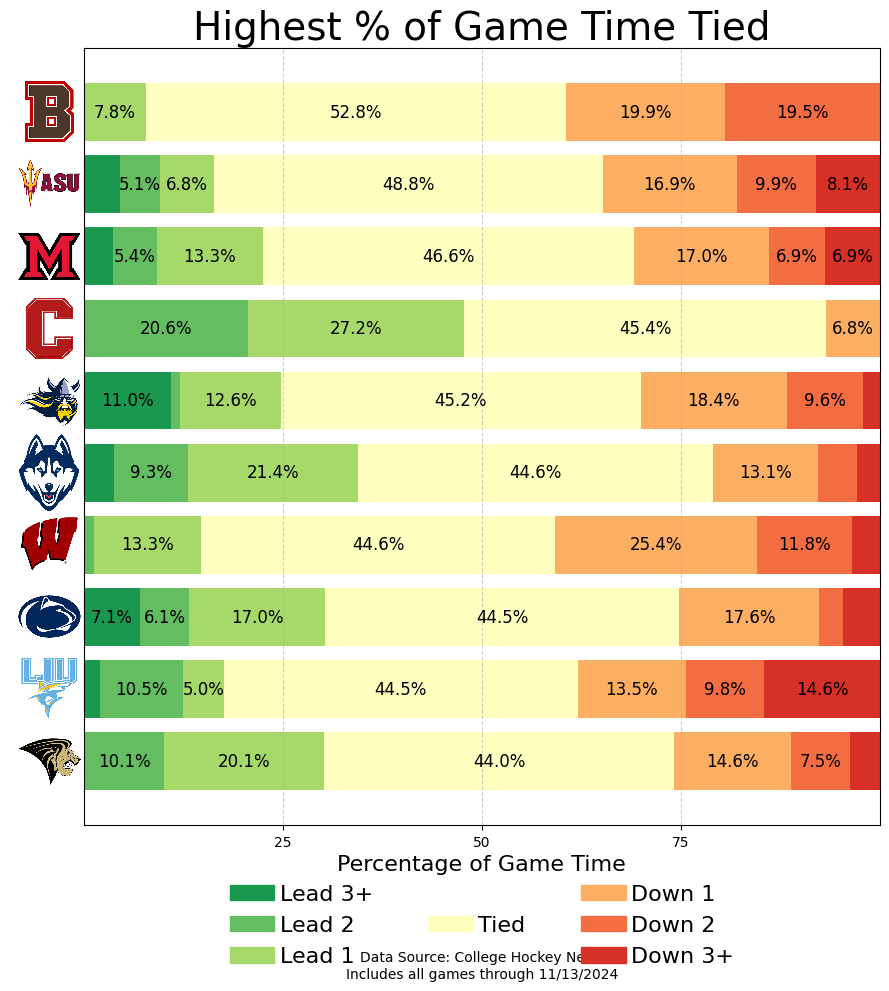

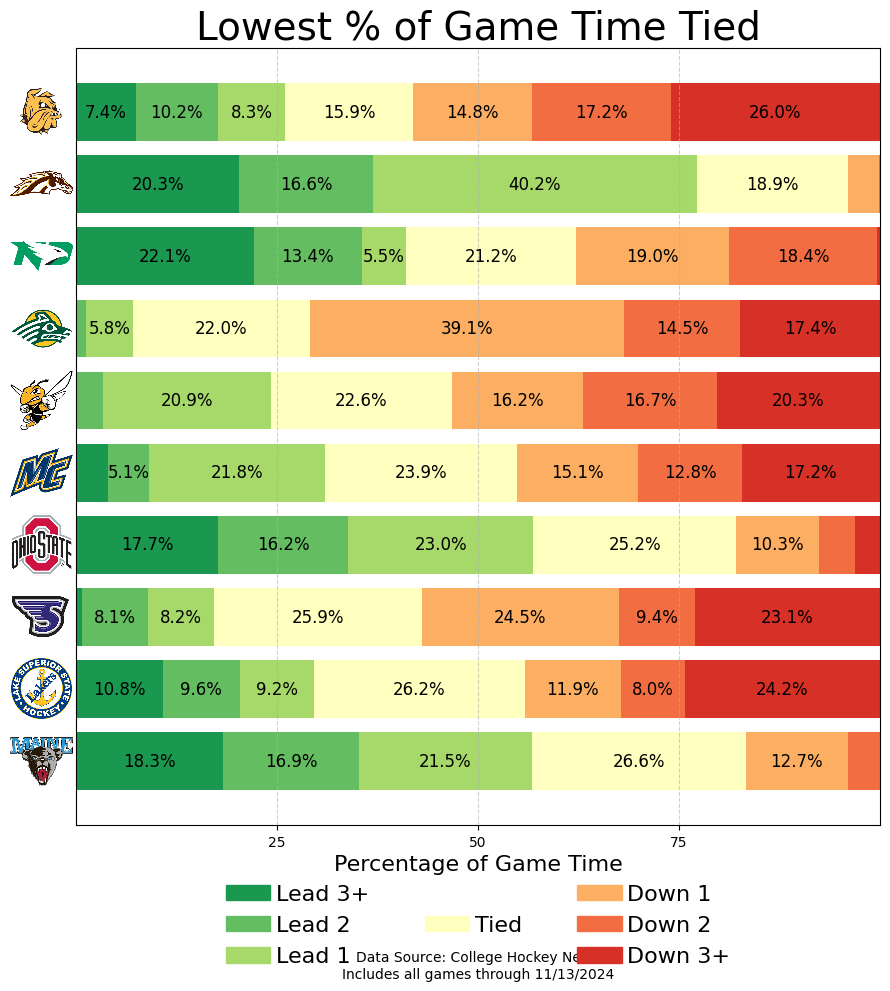

In [375]:

# Example usage:
plot_team_comparison(game_states_df, logo_mapping, logo_folder, plot_type='leading', top_n=10)
plot_team_comparison(game_states_df, logo_mapping, logo_folder, plot_type='trailing', top_n=10)
plot_team_comparison(game_states_df, logo_mapping, logo_folder, plot_type='tied', top_n=10)
plot_team_comparison(game_states_df, logo_mapping, logo_folder, plot_type='least_tied', top_n=10)


## Call Plots by Conference

In [376]:
### Dictionary of Team Names and Abbreviations
## Conference Membership

atlantic = ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
            'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart', 'St Lawrence']

big_ten = ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin']

ccha = ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
        'Minnesota State', 'Northern Michigan', 'St Thomas']

ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']

hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']

nchc = ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 'St Cloud State',
        'Western Michigan']

independents = ['Alaska Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill']


In [377]:
# Create a function to call the plot_team_comparison function for each conference

def plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference, conference_text, top_n=10):
    """
    Plot stacked bar charts of game state percentages for the top `top_n` teams within a conference,
    with labels showing the percentage within each segment if space allows,
    and team logos replacing the team names on the y-axis.
    
    Parameters:
    - game_states_df: DataFrame containing game state data.
    - logo_mapping: Dictionary mapping team names to logo file names.
    - logo_folder: Folder path where logos are stored.
    - conference: List of team names in the conference.
    - top_n: Number of top teams to display.
    """
    
    # Filter the game states data for teams in the conference
    conference_df = game_states_df[game_states_df['Team'].isin(conference)]
    
    # Calculate the total percentages for leading, trailing, and tied states
    conference_df['Total_Leading_Percentage'] = (
        conference_df['Leading_by_1_Percentage'] +
        conference_df['Leading_by_2_Percentage'] +
        conference_df['Leading_by_3+_Percentage']
    )
    conference_df['Total_Trailing_Percentage'] = (
        conference_df['Trailing_by_1_Percentage'] +
        conference_df['Trailing_by_2_Percentage'] +
        conference_df['Trailing_by_3+_Percentage']
    )
    conference_df['Total_Tied_Percentage'] = conference_df['Tied_Percentage']

    # Select the top teams based on the chosen plot type
    top_teams_df = conference_df.nlargest(top_n, 'Total_Leading_Percentage')
    title = f"{conference_text}: Game Control"
    subtitle = f"By Percentage of Time with a Lead"
    
    # Prepare data for plotting
    categories = [
        'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
        'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
    ]
    
    colors = [
        '#1A9850', '#65BD62', '#A6D86A',  # Leading: Shades of Green
        '#FFFFBF',                        # Tied: Yellow
        '#FCAE62', '#F36D42', '#D73026'   # Trailing: Shades of Red
    ]

    custom_labels = [
        'Lead 3+', 'Lead 2', 'Lead 1',
        'Tied', 'Down 1', 'Down 2', 'Down 3+'
    ]

    fig, ax = plt.subplots(figsize=set_fig_size)

    bottom = None
    for category, color in zip(categories, colors):
        if bottom is None:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
            bottom = top_teams_df[category]
        else:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
            bottom += top_teams_df[category]

        # Add labels to the segments where there's enough space
        for bar, value in zip(bars, top_teams_df[category]):
            if value > 5:  # Only show labels if the segment is larger than 5%
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + bar.get_height() / 2,
                    f"{value:.1f}%", ha='center', va='center', fontsize=12, color='black'
                )

    # Add team logos in place of the y-axis labels
    for i, team in enumerate(top_teams_df['Team']):
        logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
        if logo_path and os.path.exists(logo_path):
            try:
                logo_img = plt.imread(logo_path)
                imagebox = OffsetImage(logo_img, zoom=0.15)
                ab = AnnotationBbox(imagebox, (0, i), frameon=False, boxcoords="offset points",
                                    xybox=(-30, 0), pad=0, xycoords='data')
                ax.add_artist(ab)
            except Exception as e:
                print(f"Error adding logo for {team}: {e}")

    # Remove y-axis labels since we are using logos
    ax.set_yticks([])

    # Customize the chart
    ax.set_xlabel('Percentage of Game Time', fontsize=set_x_label_font_size)
    ax.set_title(title, fontsize=title_font_size)
    # Set subtitle
    ax.text(0.5, 0.9675, subtitle, ha='center', va='bottom', fontsize=16, transform=ax.transAxes)
    ax.set_xlim(0, 100)
    ax.set_xticks([25, 50, 75])

    # Create a custom legend layout
    legend_layout = [
        ("Lead 3+", colors[0]), ("Lead 2", colors[1]), ("Lead 1", colors[2]),
        ("", ""), ("Tied", colors[3]), ("", ""),
        ("Down 1", colors[-3]), ("Down 2", colors[-2]), ("Down 3+", colors[-1])
    ]

    handles = [plt.Rectangle((0, 0), 1, 1, color=color) if label else plt.Rectangle((0, 0), 0, 0, color='none')
               for label, color in legend_layout]

    labels = [label if label else "" for label, color in legend_layout]

    ax.legend(
        handles, labels, loc='upper center',
        bbox_to_anchor=(0.5, -0.05), ncol=3, frameon=False,
        fontsize=legend_font_size, columnspacing=2.5, handletextpad=0.25, labelspacing=0.5
    )

    # Get todays date as a string for the footer
    from datetime import date
    today = date.today()
    todays_date = today.strftime("%m/%d/%Y")

 # add a note with the date the data was pulled and plotted
    ax.text(0.5, -0.25, f'Data Source: College Hockey News. Includes all games through {todays_date}', ha='center', va='bottom',
     fontsize=10, 
    transform=ax.transAxes
    )

    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.gca().invert_yaxis()
    plt.show()


# Example usage:


C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Leading_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Trailing_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

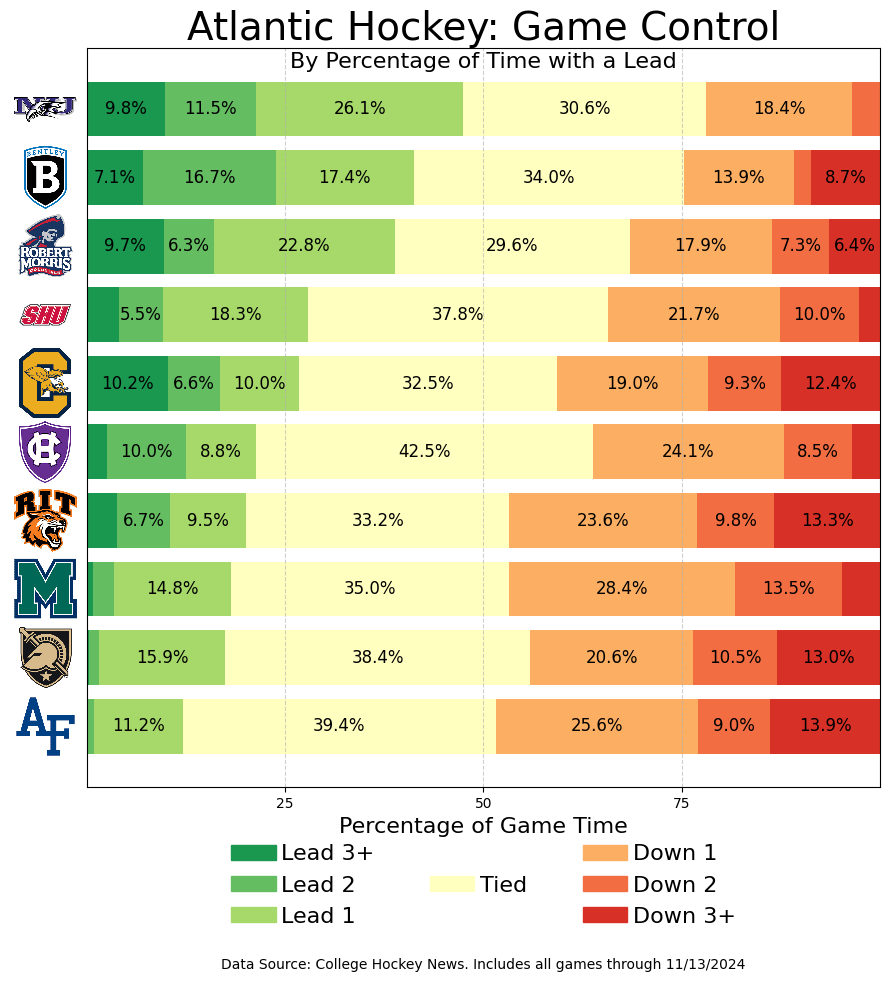

C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Leading_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Trailing_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

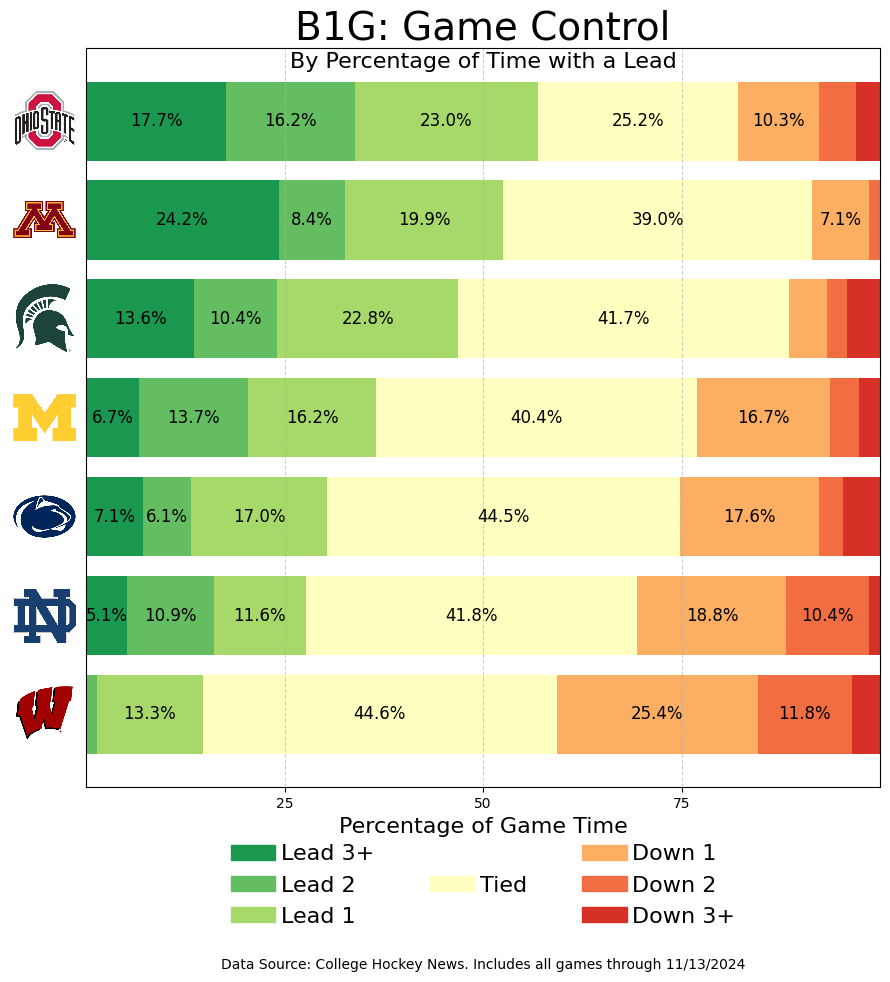

C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Leading_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Trailing_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

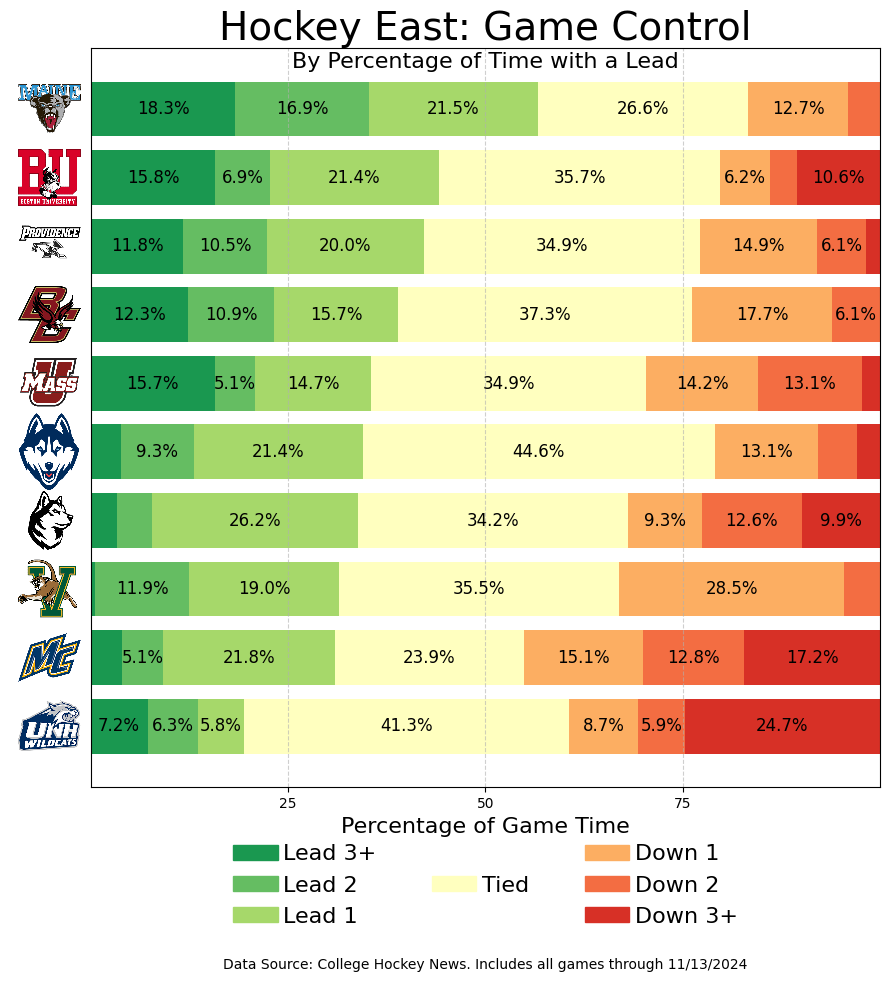

C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Leading_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Trailing_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

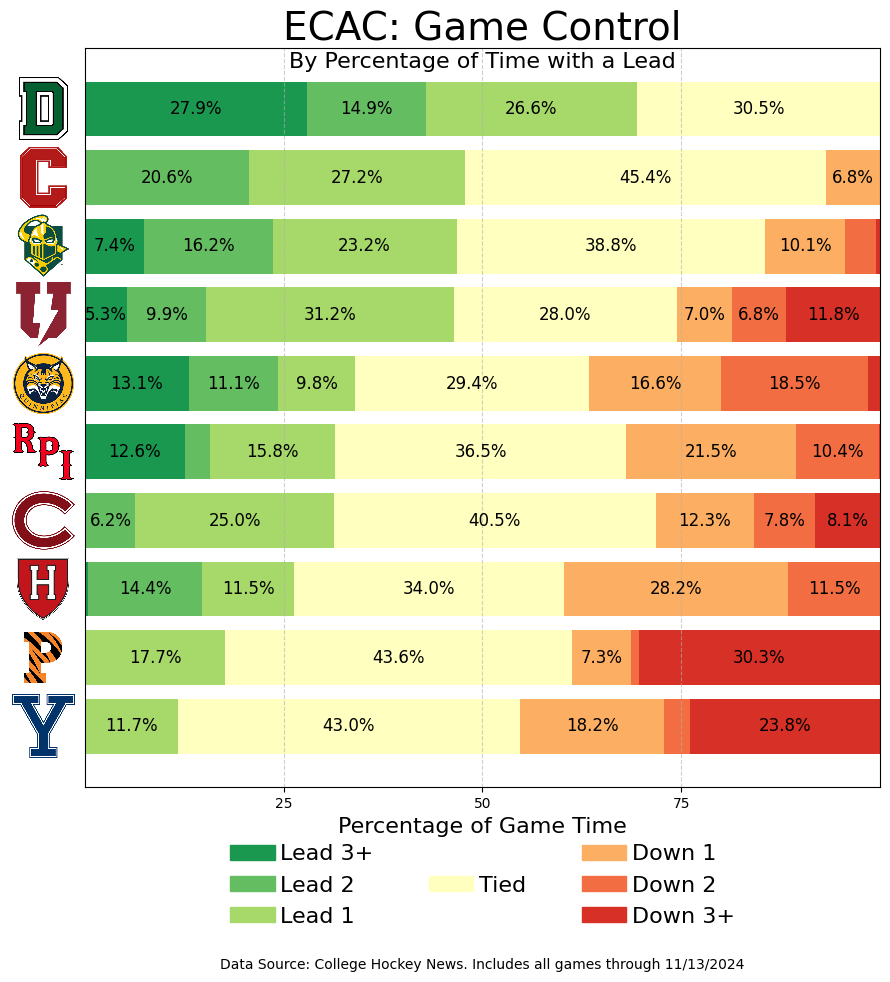

C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Leading_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Trailing_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

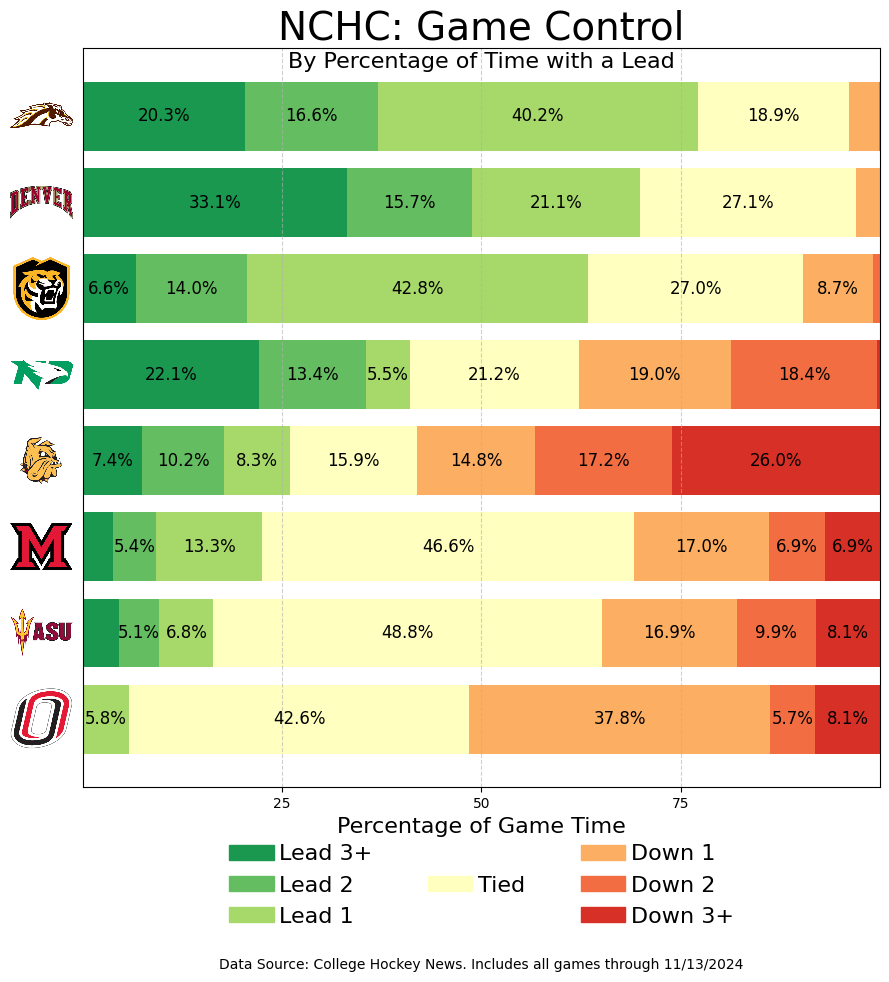

C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Leading_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Trailing_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

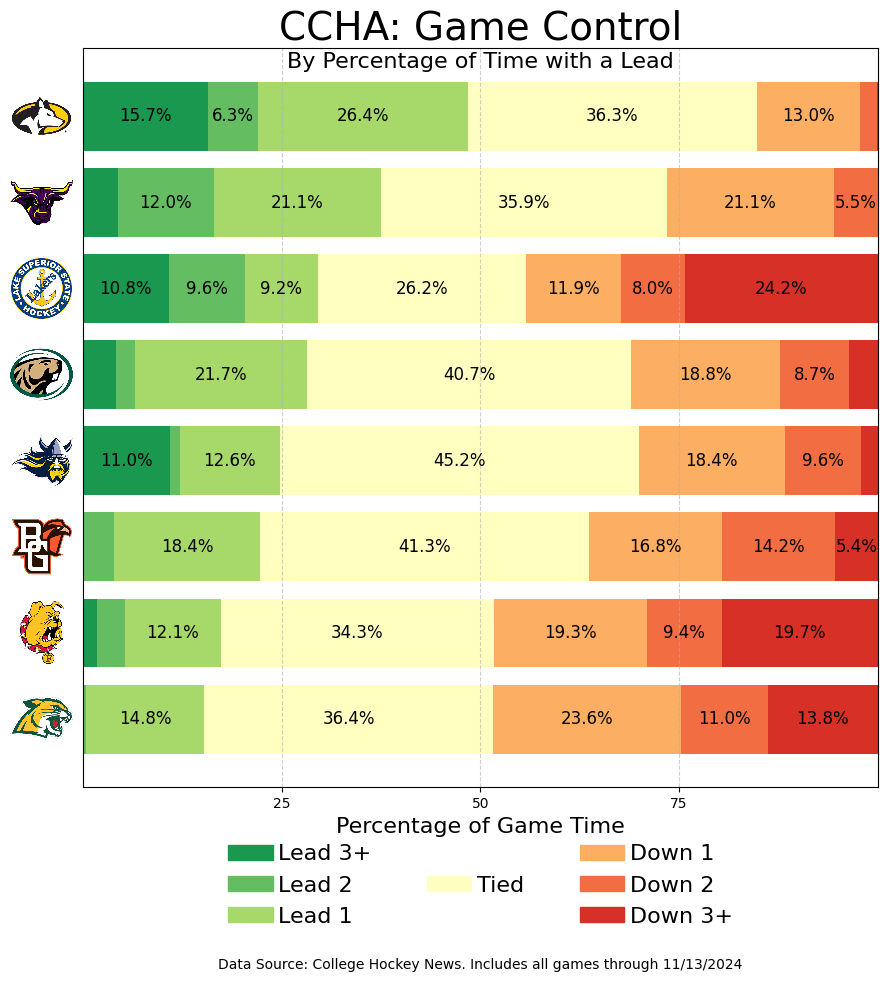

C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Leading_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conference_df['Total_Trailing_Percentage'] = (
C:\Users\jbanc\AppData\Local\Temp\ipykernel_12312\3504248049.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

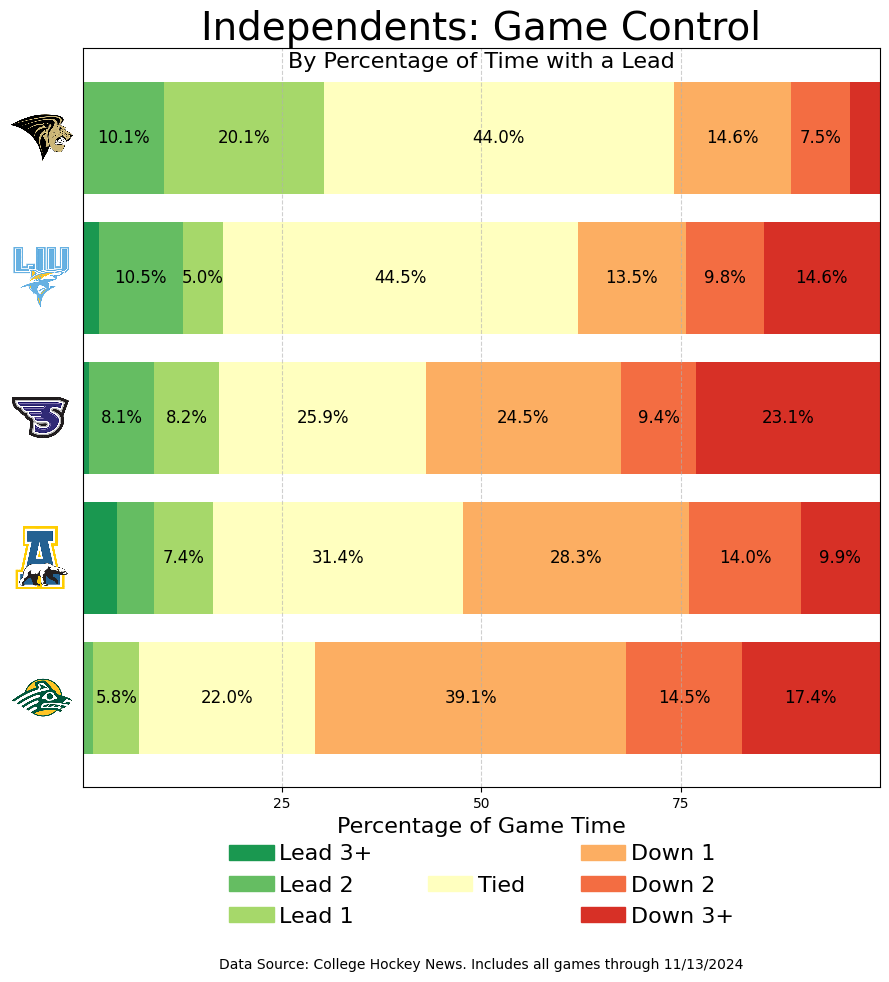

In [378]:
# Atlantic Hockey
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=atlantic, conference_text='Atlantic Hockey', top_n=10)

#B1G
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=big_ten, conference_text='B1G', top_n=10)

# Hockey East
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=hockey_east, conference_text='Hockey East', top_n=10)

# ECAC
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=ecac, conference_text='ECAC', top_n=10)

# NCHC
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=nchc, conference_text='NCHC', top_n=10)

# CCHA
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=ccha, conference_text='CCHA', top_n=10)

# Independents
plot_conference_comparison(game_states_df, logo_mapping, logo_folder, conference=independents, conference_text='Independents', top_n=10)



## OLD CODE - INITIAL VERSIONS


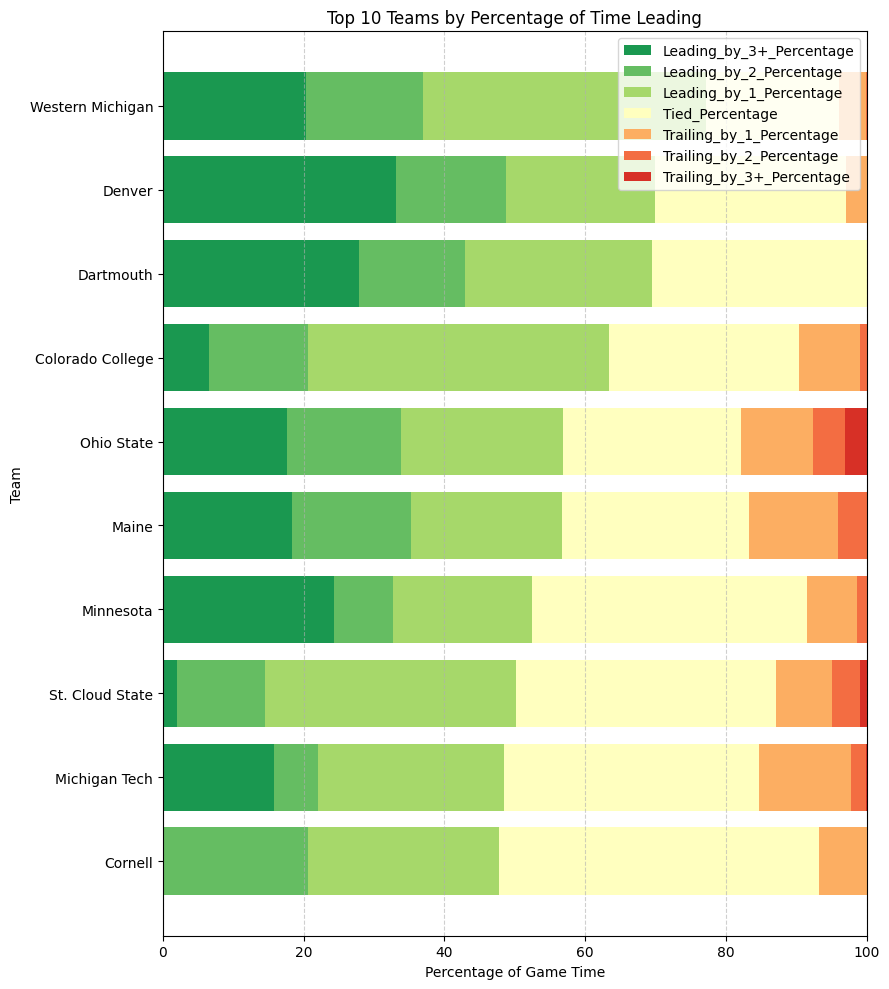

In [379]:
import matplotlib.pyplot as plt

def plot_top_teams_by_leading_percentage(game_states_df, top_n=10):
    """
    Plot stacked bar charts of game state percentages for the top `top_n` teams
    that have spent the highest percentage of time leading in games.
    """
    # Calculate the total leading percentage
    game_states_df['Total_Leading_Percentage'] = (
        game_states_df['Leading_by_1_Percentage'] +
        game_states_df['Leading_by_2_Percentage'] +
        game_states_df['Leading_by_3+_Percentage']
    )
    
    # Select the top teams by leading percentage
    top_teams_df = game_states_df.nlargest(top_n, 'Total_Leading_Percentage')
    
    # Prepare data for plotting
    categories = [
        'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
        'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
    ]
    
    # colors = [
    #     '#1A9850', '#65BD62', '#A6D86A',  # Leading: Dark Blue, Light Blue, Steel Blue
    #     '#FFFFBF',                        # Tied: Dark Gray
    #     '#FCAE62', '#F36D42', '#D73026'   # Trailing: Light Red, Orange Red, Dark Red
    # ]
    
    # Plot stacked bar chart
    fig, ax = plt.subplots(figsize=set_fig_size)
    
    bottom = None
    for category, color in zip(categories, colors):
        if bottom is None:
            ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
            bottom = top_teams_df[category]
        else:
            ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
            bottom += top_teams_df[category]
    
    # Customize the chart
    ax.set_xlabel('Percentage of Game Time')
    ax.set_ylabel('Team')
    ax.set_title(f'Top {top_n} Teams by Percentage of Time Leading')
    ax.set_xlim(0, 100)
    ax.legend(loc='upper right')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.gca().invert_yaxis()  # Ensure top team is at the top of the chart
    
    # Show the plot
    plt.show()

# Call the function to plot the chart
plot_top_teams_by_leading_percentage(game_states_df)


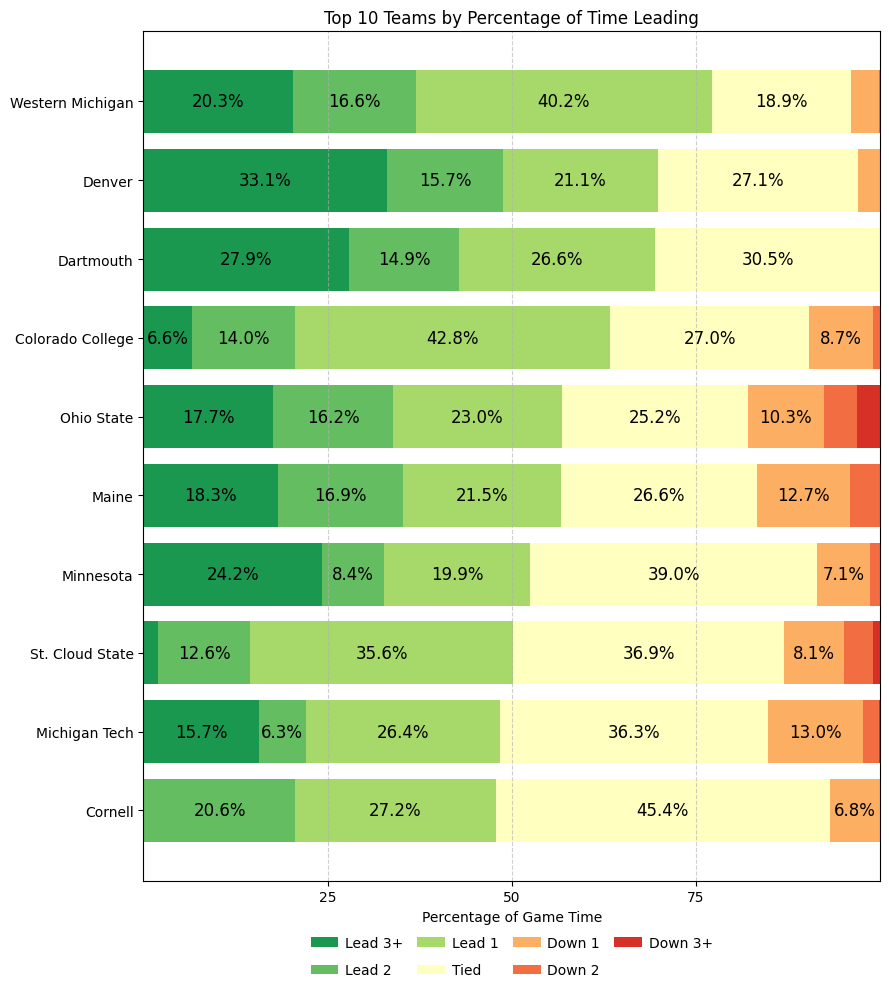

In [380]:
import matplotlib.pyplot as plt

def plot_top_teams_with_labels(game_states_df, top_n=10):
    """
    Plot stacked bar charts of game state percentages for the top `top_n` teams,
    with labels showing the percentage within each segment if space allows.
    """
    # Calculate the total leading percentage
    game_states_df['Total_Leading_Percentage'] = (
        game_states_df['Leading_by_1_Percentage'] +
        game_states_df['Leading_by_2_Percentage'] +
        game_states_df['Leading_by_3+_Percentage']
    )
    
    # Select the top teams by leading percentage
    top_teams_df = game_states_df.nlargest(top_n, 'Total_Leading_Percentage')
    
    # Prepare data for plotting
    categories = [
        'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
        'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
    ]
    
    colors = [
        '#1A9850', '#65BD62', '#A6D86A',  # Leading: Shades of Green
        '#FFFFBF',                        # Tied: Yellow
        '#FCAE62', '#F36D42', '#D73026'   # Trailing: Shades of Red
    ]

    custom_labels = [
        'Lead 3+', 'Lead 2', 'Lead 1', 
        'Tied', 'Down 1', 'Down 2', 'Down 3+'
    ]
    
    fig, ax = plt.subplots(figsize=set_fig_size)
    
    bottom = None
    for category, color in zip(categories, colors):
        if bottom is None:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
            bottom = top_teams_df[category]
        else:
            bars = ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
            bottom += top_teams_df[category]
        
        # Add labels to the segments where there's enough space
        for bar, value in zip(bars, top_teams_df[category]):
            if value > 5:  # Only show labels if the segment is larger than 5%
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # Center of the segment
                    bar.get_y() + bar.get_height() / 2,  # Center of the bar
                    f"{value:.1f}%",  # Label with one decimal place
                    ha='center', va='center', fontsize=12, color='black'
                )
    
    # Customize the chart
    ax.set_xlabel('Percentage of Game Time')
    # ax.set_ylabel('Team')
    ax.set_title(f'Top {top_n} Teams by Percentage of Time Leading')
    ax.set_xlim(0, 100)
    ax.set_xticks([25, 50, 75])  # Set custom tick marks at 25, 50, and 75
    
    # Customize the legend with 3 rows
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(
        handles, custom_labels, loc='upper center',
        bbox_to_anchor=(0.5, -0.05), 
        ncol=4,
        frameon=False, fontsize=10,
        # title='Game States', title_fontsize=12,
        columnspacing=1.0, handletextpad=0.5,
        labelspacing=1.0
    )
    # ax.legend(loc='upper right')

    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.gca().invert_yaxis()  # Ensure top team is at the top of the chart
    
    # Show the plot
    plt.show()

# Call the function to plot the chart with labels
plot_top_teams_with_labels(game_states_df)


### Time Spent Tied

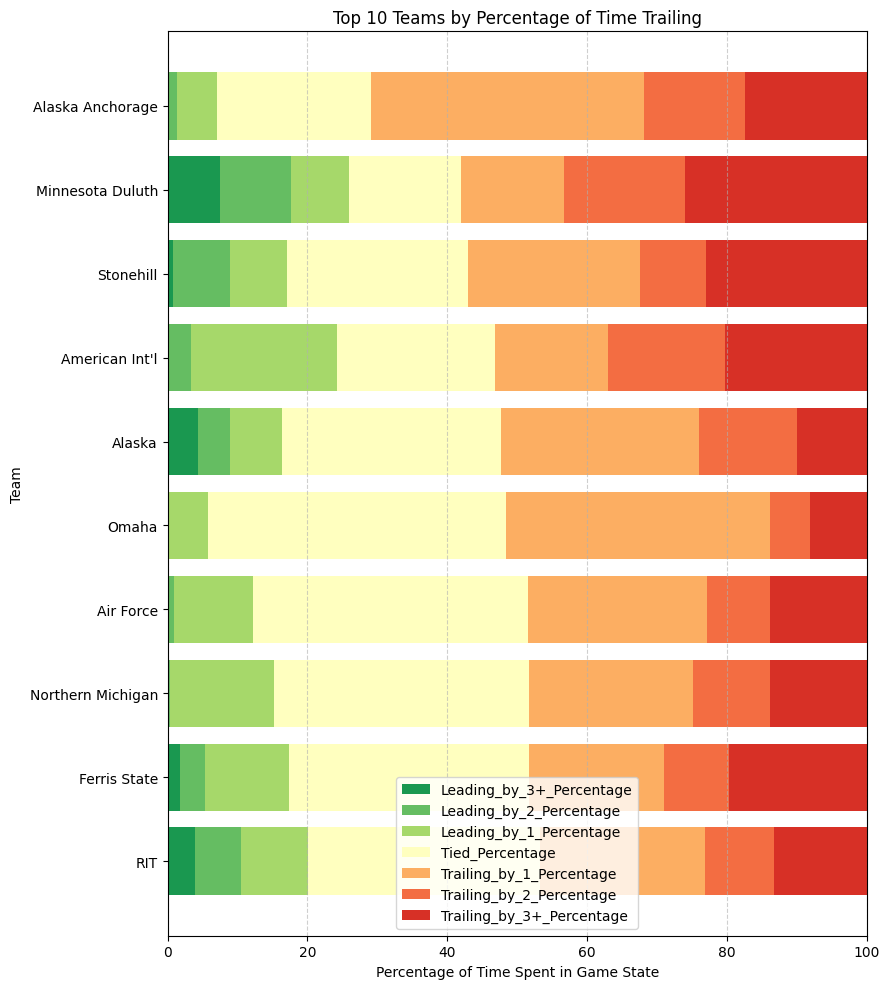

In [381]:
## Create a compilmentary function to plot the top teams by trailing percentage

def plot_top_teams_by_trailing_percentage(game_states_df, top_n=10):
    """
    Plot stacked bar charts of game state percentages for the top `top_n` teams
    that have spent the highest percentage of time trailing in games.
    """
    # Calculate the total trailing percentage
    game_states_df['Total_Trailing_Percentage'] = (
        game_states_df['Trailing_by_1_Percentage'] +
        game_states_df['Trailing_by_2_Percentage'] +
        game_states_df['Trailing_by_3+_Percentage']
    )
    
    # Select the top teams by trailing percentage
    top_teams_df = game_states_df.nlargest(top_n, 'Total_Trailing_Percentage')

    # Reorder the teams by total trailing percentage
    top_teams_df = top_teams_df.sort_values('Total_Trailing_Percentage', ascending=True)
    
    # Prepare data for plotting
    categories = [
        'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
        'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
    ]
    
    colors = [
        '#1A9850', '#65BD62', '#A6D86A',  # Leading: Dark Blue, Light Blue, Steel Blue
        '#FFFFBF',                        # Tied: Dark Gray
        '#FCAE62', '#F36D42', '#D73026'   # Trailing: Light Red, Orange Red, Dark Red
    ]

                   
    # Plot stacked bar chart
    fig, ax = plt.subplots(figsize=set_fig_size)
    
    bottom = None
    for category, color in zip(categories, colors):
        if bottom is None:
            ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
            bottom = top_teams_df[category]
        else:
            ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
            bottom += top_teams_df[category]
    
    # Customize the chart
    ax.set_xlabel('Percentage of Time Spent in Game State')
    ax.set_ylabel('Team')
    ax.set_title(f'Top {top_n} Teams by Percentage of Time Trailing')
    ax.set_xlim(0, 100)
    ax.legend(loc='lower center')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    # plt.gca().invert_yaxis

    
    
    

    

## Call the function to plot the chart
plot_top_teams_by_trailing_percentage(game_states_df)

### Top Ten Time Spent Tied

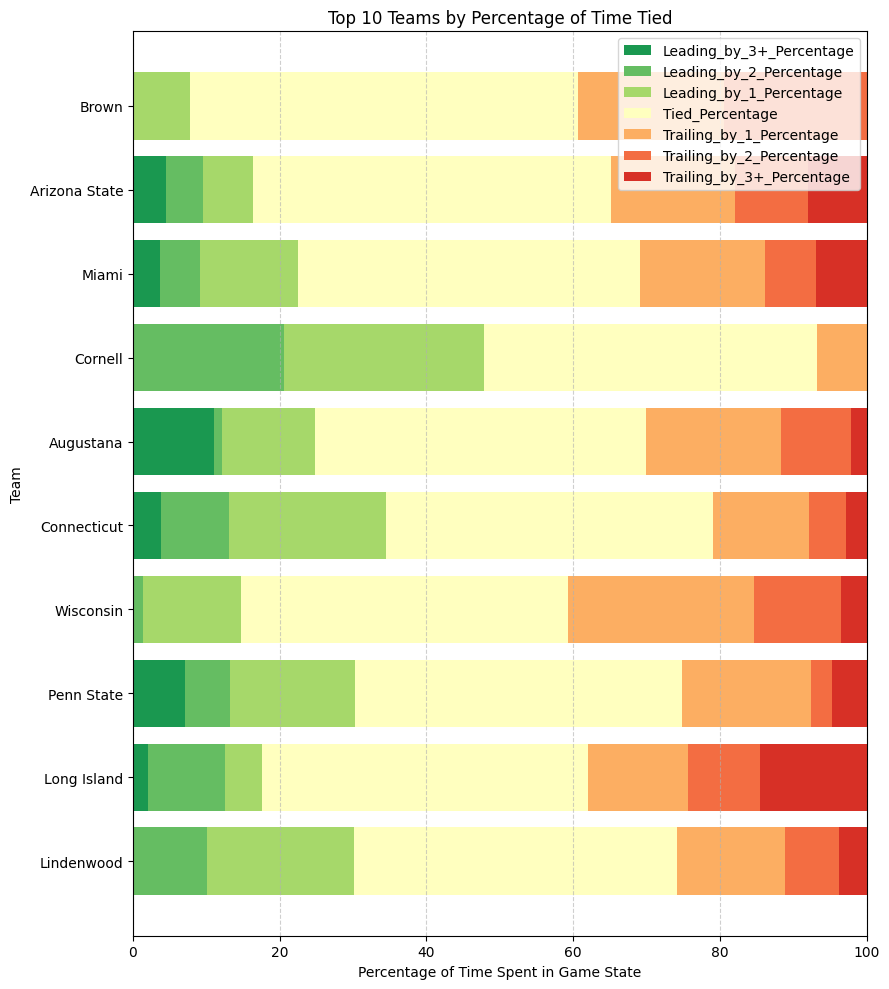

In [382]:
## Adapt the plot to show the top teams by tied percentage

def plot_top_teams_by_tied_percentage(game_states_df, top_n=10):
    """
    Plot stacked bar charts of game state percentages for the top `top_n` teams
    that have spent the highest percentage of time tied in games.
    """
    # Select the top teams by tied percentage
    top_teams_df = game_states_df.nlargest(top_n, 'Tied_Percentage')
    
    # Prepare data for plotting
    categories = [
        'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
        'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
    ]
    
    colors = [
        '#1A9850', '#65BD62', '#A6D86A',  # Leading: Dark Blue, Light Blue, Steel Blue
        '#FFFFBF',                        # Tied: Dark Gray
        '#FCAE62', '#F36D42', '#D73026'   # Trailing: Light Red, Orange Red, Dark Red
    ]
    
    # Plot stacked bar chart
    fig, ax = plt.subplots(figsize=set_fig_size)
    
    bottom = None
    for category, color in zip(categories, colors):
        if bottom is None:
            ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category)
            bottom = top_teams_df[category]
        else:
            ax.barh(top_teams_df['Team'], top_teams_df[category], color=color, label=category, left=bottom)
            bottom += top_teams_df[category]
    
    # Customize the chart
    ax.set_xlabel('Percentage of Time Spent in Game State')
    ax.set_ylabel('Team')
    ax.set_title(f'Top {top_n} Teams by Percentage of Time Tied')
    ax.set_xlim(0, 100)
    ax.legend(loc='upper right')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.gca().invert_yaxis()  # Ensure top team is at the top of the chart
    
    # Show the plot
    plt.show()


## Call the function to plot the chart
plot_top_teams_by_tied_percentage(game_states_df)

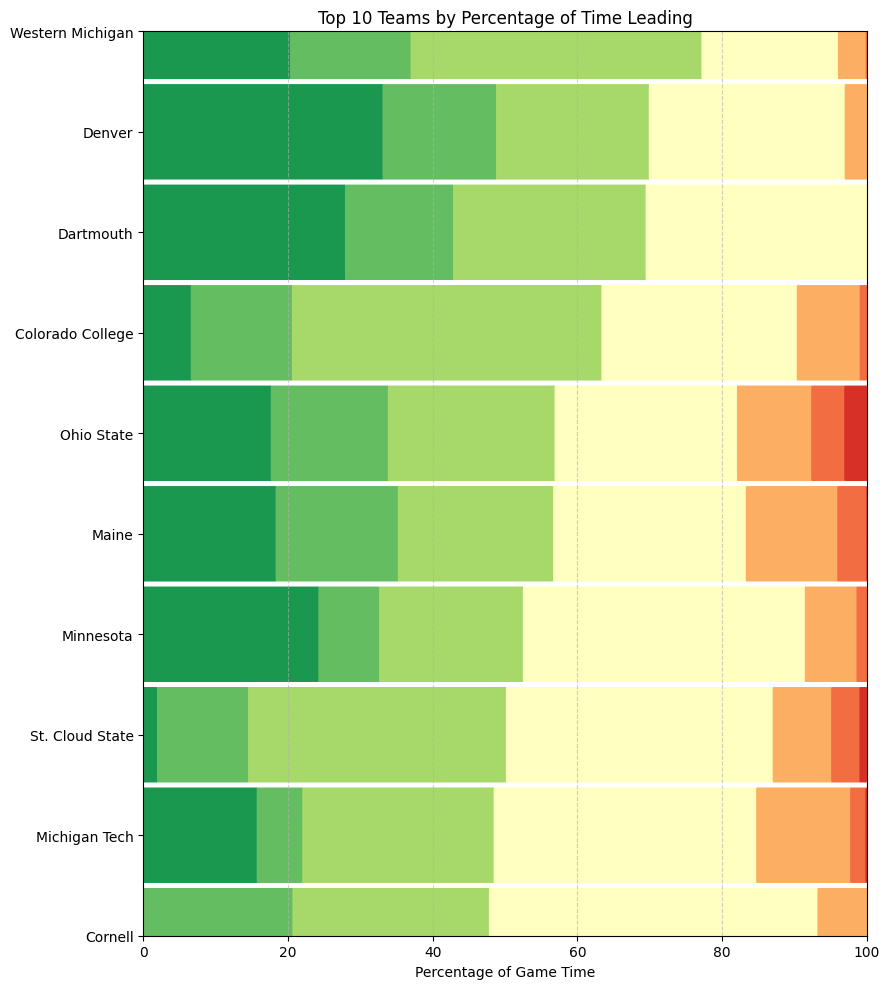

In [383]:
import numpy as np
import matplotlib.patches as patches

colors = [
    '#1A9850', '#65BD62', '#A6D86A',  # Leading: Dark Blue, Light Blue, Steel Blue
    '#FFFFBF',                        # Tied: Dark Gray
    '#FCAE62', '#F36D42', '#D73026'   # Trailing: Light Red, Orange Red, Dark Red
]

def plot_top_teams_with_smooth_transitions(game_states_df, top_n=10):
    """
    Plot stacked bar charts of game state percentages for the top `top_n` teams
    with smooth ribbon-like transitions between segments.
    """
    # Calculate the total leading percentage
    game_states_df['Total_Leading_Percentage'] = (
        game_states_df['Leading_by_1_Percentage'] +
        game_states_df['Leading_by_2_Percentage'] +
        game_states_df['Leading_by_3+_Percentage']
    )
    
    # Select the top teams by leading percentage
    top_teams_df = game_states_df.nlargest(top_n, 'Total_Leading_Percentage')
    
    # Prepare data for plotting
    categories = [
        'Leading_by_3+_Percentage', 'Leading_by_2_Percentage', 'Leading_by_1_Percentage',
        'Tied_Percentage', 'Trailing_by_1_Percentage', 'Trailing_by_2_Percentage', 'Trailing_by_3+_Percentage'
    ]

    ## OLD PALLETE    
    # colors = [
    #     '#1E90FF', '#87CEFA', '#4682B4',  # Leading: Dark Blue, Light Blue, Steel Blue
    #     '#A9A9A9',                        # Tied: Dark Gray
    #     '#FF7F7F', '#FF4500', '#B22222'   # Trailing: Light Red, Orange Red, Dark Red
    # ]
    
    fig, ax = plt.subplots(figsize=set_fig_size)
    y_positions = np.arange(len(top_teams_df))
    bar_height = 0.85
    
    for idx, team in enumerate(top_teams_df['Team']):
        left = 0
        for category, color in zip(categories, colors):
            width = top_teams_df.loc[top_teams_df['Team'] == team, category].values[0]
            if width > 0:
                # Draw a rounded rectangle for smooth transitions
                ax.add_patch(patches.FancyBboxPatch(
                    (left, y_positions[idx] - bar_height / 2),
                    width,
                    bar_height,
                    boxstyle="round,pad=0.05",
                    edgecolor='none',
                    facecolor=color
                ))
                left += width
    
    # Customize the chart
    ax.set_yticks(y_positions)
    ax.set_yticklabels(top_teams_df['Team'])
    ax.set_xlabel('Percentage of Game Time')
    ax.set_title(f'Top {top_n} Teams by Percentage of Time Leading')
    ax.set_xlim(0, 100)
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    plt.gca().invert_yaxis()  # Ensure top team is at the top of the chart
    plt.tight_layout()
    
    # Display the plot
    plt.show()

# Call the function to generate the plot with smooth transitions
plot_top_teams_with_smooth_transitions(game_states_df)
